# Interatomic force field (IFF) optimization for W-based metal alloys

Author: Lukas Vlcek

Start Date: 2018-04-22

In [1]:
from datetime import datetime ; print('Last update:', datetime.now())

Last update: 2018-07-25 21:53:17.329834


# Table of Contents

* [1. Introduction](#1.-Introduction)
* [2. Theoretical background](#2.-Theoretical-background)
    * [2.1 Model definition](#2.1-Model-definition)
    * [2.2 Optimization approach](#2.2-Optimization-approach)
        * [2.2.1 Perturbation technique](#2.2.2-Perturbation-technique)
        * [2.2.2 Statistical distance loss function](#2.2.1-Statistical-distance-loss-function)
    * [2.3 Target data](#2.3-Target-data)
    * [2.4 Simulation details](#2.4-Simulation-details)
* [3. Results](#3.-Results)
    * [3.1 Initial model](#3.1-Initial-model)

**Notebook setup**

In [2]:
# Import libraries
%matplotlib inline
import os
import glob
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
import h5py
from itertools import product

# Paths to important directories
pot_path = '../sim/potentials'
target_raw = '../data/target_raw'
target_proc = '../data/target_processed'

## 1. Introduction

**Goal:** Optimize EAM potential for W using the functional form of Bonny et al. (2017), and target data from Marinica et al. (2013) and German. Show that using this simplified EAM form we can develop a more predictive model of W compared to EAM2 model of Marinica.

## 2. Theoretical background

### 2.1 Model definition

**Equilibrium potential**

Energy of an N-particle configuration

$$ E = \sum_{i=1}^N \left[ \sum_{j>i}^N V_{t_it_j}\left(r_{ij}\right) + F_{t_i}\left(\rho_i\right) \right] $$

Here $V_{t_it_j}$ is pair interaction between atom types $t_i$ and $t_j$ at distance $r_{ij}$ defined as

$$ V_{t_it_j}\left(r_{ij}\right) = \sum_{k=1}^{N_p}\left[a_k\left(r_k - r_{ij}\right)^3\Theta\left(r_k - r_{ij}\right)\right]\ $$

where $\Theta$ is Heaviside step function.
$F_{t_i}$ is the manybody embedding function

$$ F_{t_i}(\rho_i) = A_{t_i}\sqrt{\rho_i} + B_{t_i}\rho + C_{t_i}\rho^2 $$

where $\rho_i$ effective electron density 

$$ \rho_i = \sum_{j\ne i}^N \phi_{t_j}\left(r_{ij}\right) $$

and $\phi$ is cohesive potential

$$ \phi\left(r_{ij}\right) = D_{t_j}\left(r_c - r_{ij}\right)^3\Theta\left(r_c - r_{ij}\right) $$

In [3]:
# Define the equilibrium EAM functions (to be optimized)

# Pair potential (cubic splines). Parameters: distance (r), spline parameters (aa), spline nodes (cc)
V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Embedding function. Parameters: electronic density (d), coefficients for 1/2, 1, and 2 powers of density
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

# Cohesive potential (cubic splines - same form as V)
phi = V

**Core and transition potential for short and intermediate distances**

In [4]:
# Define the core and transition parts of the potential (kept constant)
def u_core(r, za=74, zb=74):
    """Repulsive potential of the atomic cores. Default atomic numbers for W"""
    qe_sq = 14.3992 # squared electron charge  
    rs = 0.4683766/(za**(2/3) + zb**(2/3))**0.5
    x = r/rs
    u  = 0.1818*np.exp(-3.2*x)
    u += 0.5099*np.exp(-0.9423*x)
    u += 0.2802*np.exp(-0.4029*x)
    u += 0.02817*np.exp(-0.2016*x)
    u *= za*zb*qe_sq/r
    return u

def u_trans(r, unucl, ueq, ri=1.0, ro=2.0):
    """Transition between the core and equillibrium potentials"""
    if r < ri:
        return unucl
    elif r < ro:
        x = (ro + ri - 2*r)/(ro - ri)
        eta = 3/16*x**5 - 5/8*x**3 + 15/16*x + 1/2
        return ueq + eta*(unucl - ueq)
    else:
        return ueq    

### 2.2 Optimization approach

#### 2.2.1 Perturbation technique

**Pair distances**

In [6]:
def pair_dist(xyz, box):
    """
    Calculates nearest image pair distances between all atoms in xyz array.
    Parameters
    -----------
    xyz : numpy array
          particle x, y, z coordinates
    box : scalar or numpy array
          simulation box dimensions/shape
    Returns
    -------
    rr  : (natom, natom) numpy array of pair distances
    rx  : (natom, natom, 3) numpy array of pair distance coordinates
    """

    n_atom = xyz.shape[0] # number of atoms in a configuration
    rr = np.empty((n_atom, n_atom), dtype=float)
    rx = np.empty((n_atom, n_atom, 3), dtype=float)

    for i, pa in enumerate(xyz):
        for j, pb in enumerate(xyz):
            dp = pa - pb
            dp = np.where(dp < -0.5*box, dp + box, dp)
            dp = np.where(dp >  0.5*box, dp - box, dp)
            rr[i,j] = np.sum(dp*dp)**0.5
            rx[i,j] = dp
        
    return rr, rx

**EAM sufficient statistics**

In [6]:
def get_stats_EAM(rr, rx, sc):
    """
    Takes atom pair distances and calculates sufficeint statistics needed
    for the parameterization of a cubic spline-based EAM model by Bonny et al. (2017).
    
    Parameters
    ----------
    rr : numpy array
         set of pair distances
    rx : numpy array
         set of pair distance coordinates
    sc : python list
         spline nodes
         
    Returns
    -------
    ar, a1, a2 : numpy arrays (len(sc))
                 atom energy-related statistics
                 el_density**0.5, el_density, el_density**2
    br, b1, b2 : numpy arrays (len(sc), natoms, 3 coordinates)
                 atom force-related statistics (gradients of energy)
                 grad(el_density**0.5), grad(el_density), grad(el_density**2)
    """
    
    # number of atoms in configuration
    n_atom = rr.shape[0]
    
    # energy-related statistics
    aa = np.empty((n_atom), dtype=float)
    ar = np.zeros((len(sc)), dtype=float)
    a1 = np.zeros_like(ar)
    a2 = np.zeros_like(ar)
    
    # force-related statistics
    br = np.zeros((len(sc), n_atom, 3), dtype=float)
    b1 = np.zeros_like(br)
    b2 = np.zeros_like(br)
    zero3 = np.zeros((3), dtype=float)

    # cycle over spline nodes
    for ks, rc in enumerate(sc):
        
        # cycle over atoms
        for i in range(n_atom):
            
            # sum electronic density over all neighbors of i within rc
            aa[i] = sum([(rc - r)**3 for r in rr[i] if (r < rc and r > 0.01)])

            # if el. density larger than zero, calculate force statistics
            if aa[i] > 0.0:
                
                # precompute a list of recurring values for force statistics
                ff = [1.5*(rc - r)**2*x/r if (r > 0.01 and r < rc) else zero3 for r, x in zip(rr[i], rx[i])]
                
                # sum contributions to force statistics from all neighbors of i
                b1[ks, i] = sum([2*f       for f in ff])
                br[ks, i] = sum([ -f/np.sqrt(aa[i]) for f in ff])
                b2[ks, i] = sum([4*f*aa[i] for f in ff])

        # sum contributions to energy statistics for a given spline node
        ar[ks] = np.sum(np.sqrt(aa))
        a1[ks] = np.sum(aa)
        a2[ks] = np.sum(aa**2)
        
    return a1, ar, a2, b1, br, b2

**EAM configurational energy based on sufficient statistics and model parameters**

In [16]:
def utot_EAM(params, ustats):
    """
    Calculates configurational energy from EAM sufficient statistics and model parameters

    Parameters
    ----------
    params : list of lists and floats
             EAM interaction parameters (spline coefficients array and embedding function parameters)
    ustats : list of lists and floats
             Sufficient statistics for a trajectory of configurations

    Returns
    -------
    u_total: float
             total configurational energy (sum of pair and manybody interactions) for trajectory of configurations
    """

    n_sample = stats.shape[0]

    # pair interactions from array of spline coefficeints and corresponding statistic
    u_pair = np.array([sum([a*s for a, s in zip(params[0], ustats[i, 0])]) for i in range(n_sample)])

    # manybody interactions from embedding function parameters and corresponding statistics
    u_many = np.array([params[1]*ustats[i, 1] + params[2]*ustats[i,2] for i in range(n_sample)])

    u_total = u_pair + u_many

    return u_total

In [17]:
def ftot_EAM(params, fstats):
    """
    Calculates configurational energy from EAM sufficient statistics and model parameters

    Parameters
    ----------
    params : list of lists and floats
             EAM interaction parameters (spline coefficients array and embedding function parameters)
    fstats : list of lists and floats
             Sufficient statistics

    Returns
    -------
    f_total: float
             total configurational energy (sum of pair and manybody interactions)
    """

    # number of samples and atoms
    n_sample = stats.shape[0]
    n_atom = stats.shape[1]

    f_total = np.zeros((n_sample, 6*n_atom + 1), dtype=float)

    # cycle over samples
    for i in range(n_sample):

        # pair interactions from array of spline coefficeints and corresponding statistic
        f_pair = sum([p*s for p, s in zip(params[0], fstats[i,0])]) 

        # manybody interactions from embedding function parameters and corresponding statistics
        f_many = params[1]*fstats[i,1] + params[2]*fstats[i,2]

        # Create a 6N + 1 array of 0, f, and -f
        f_total[1:3*n_atom+1] = f_pair.flatten() + f_many.flatten()
        f_total[3*n_atom+1:] = -f_total[1:3*n_atom+1]
            
    return f_total

#### 2.2.2 Statistical distance loss function

**Loss function based on configurational energies and forces**

In [18]:
def sd2_loss(params, stats, targets, weights=None):
    """
    Calculates squared statistical distance loss function for configurational energies and forces.

    Parameters
    ----------
    params : list of lists and floats
             EAM interaction parameters (spline coefficients array and embedding function parameters)
    stats  : list of lists and floats
             Sufficient statistics
    targets: list of lists and floats
             target energies and forces
    weights: weighting of different target data

    Returns
    -------
    sd2, sd2f: float
               squared statistical distances between model and target (energy and force-based)
    """

    # apply bounds on parametes
    #p = np.where(p < -1.0, -1.0, p)
    #p = np.where(p >  1.0,  1.0, p)

    # if weights not provided, assign equal weights
    if not weights:
        weights = np.ones((len(targ)), dtype=float)

    # cycle over target system trajectories and statistics to determine SD
    sd2 = sd2f = 0.0
    for targ, stat, w in zip(targets, stats, weights):

        beta = targ['beta'] # system inverse temperature
        u_targ = targ['energy'] # target energies
        u_stat = stat['energy'] # energy statistics
        u_pars = params[0]
        n_sample = u_targ.shape[0]

        # energy diference array for a given target trajectory
        uuu = beta*(utot_EAM(u_pars, u_stat) - u_targ) # array(n_sample)
        uuu -= np.mean(uuu)
        eee = np.exp(-uuu)
 
        # are forces available?
        if 'forces' not in targ:

            # energy-based free energy difference and statistical distance
            ge = -np.log(np.mean(eee))   # free energy difference (shifted)
            cb = np.mean(np.exp(-0.5*(uuu - ge))) # Bhattacharyya coefficient
            sd2 += w*np.arccos(cb)**2              # statistical distance

        else:

            betad = beta*0.01  # beta * dl
            f_targ = targ['forces'] # target forces (n_sample, 1+6N) (0, 3Nf, -3Nf)
            f_stat = stat['forces'] # force statistics (n_sample, npars, 3N)
            f_pars = params[1]

            eeh = np.exp(-0.5*uuu)
            fff = ftot_EAM(f_pars, f_stat) # n_sample *(6N + 1) force contributions

            # target and model force terms
            fpave = np.mean(np.exp(betad*f_targ))
            fqave = np.mean([eee[i]*np.mean(np.exp(betad*fff[i])) for i in range(n_sample)])
            fhave = np.mean([eeh[i]*np.mean(np.exp(0.5*betad*(fff[i]+f_targ[i]))) for i in range(n_sample)])
            
            # force-based free energy difference and statistical distance
            gef = -np.log(fqave/fpave)
            cb = fhave/(fqave*fpave)**0.5
            if cb > 1: cb = 1
            sd2f += w*np.arccos(cb)**2

    return sd2 + sd2f

In [11]:
def thermo(params, stats, targets):
    """
    Calculates squared statistical distance loss function for configurational energies and forces.
    
    Parameters
    ----------
    params : list of lists and floats
             EAM interaction parameters (spline coefficients array and embedding function parameters)
    stats  : list of lists and floats
             Sufficient statistics
    targets: list of lists and floats
             target energies and forces
    
    Returns
    -------
    ge, he, se : floats
                 free energy, enthalpy, and entropy differences
    """
    
    for targ, stat in zip(targets, stats):
        beta = targ['beta'] # system inverse temperature
        u_targ = targ['energy'] # target energies
        u_stat = stat['energy'] # energy statistics

        # energy diference array for a given target trajectory
        uuu = beta*(utot_EAM(params, u_stat) - u_targ)
        uave = np.mean(uuu)
        uuu -= uave
        eee = np.exp(-uuu)

        ge = np.mean(eee)
        he = (np.mean(eee*(beta*hee + uuu + uave))/ge - beta*np.mean(hee))/beta
        
        ge = -np.log(ge)
        eee = np.exp(-0.5*(uuu - ge))
        ge = (ge + uave)/beta
        se = he - ge

    return ge, he, se

### 2.3 Target data

**Bulk properties of tungsten** (from _Marinica et.al_ except for B (bulk modulus) and Pc (Cauchy pressure)) T=0K?

| Property | BCC | FCC |
| :---     | :---: | :---: |
| a_0 (A) | 3.1648 | 4.054 |
| E_coh (eV/atom) | -8.9 | -8.43 |
| C11 (GPa) | 523 | - |
| C12 (GPa) | 203 | - |
| C44 (GPa) | 160 | - |
| B (GPa) | 310.4 | - |
| Pc (GPa) | 21.9 | - |

**Defect properties** (from _Marinica et.al_), based on 128+-1 atoms

Defect | Energy (eV)
:--- | :---:
(111) | 10.53
(110) | 10.82
(100) | 12.87
OCT | 13.11
TET | 12.27
Vacancy | 3.49

**List of available atomic configurations and DFT data**

1. Data from Marinica
  * 20 configurations generated from liquid Fe trajectory, N=113
  * DFT Forces
  * DFT Energy
2. Data from German (local minimum energy configs.)
  * Energy, Hessians?
  * Pure phases
    * BCC (54 atoms)
    * FCC (32 atoms)
  * Vacancy
    * vacancy (53 atoms)
  * Interstitial defects 
    * 110, 111 (55 atoms)
  * Screw dislocation
    * 111_easy_core (135 atoms)?

**Universal equation of state for metals at 0K**

In [13]:
# W parameters
l = 0.274
r_wse = 3.168
r_wse = 1.584
eta = 5.69
dE = 8.9

# equation of state. x is lattice expansion/compression parameter
def eos(x):
    a = (x - 1.0)*r_wse/l
    ene = np.exp(-a)
    ene *= -1.0 - a - 0.05*a**3
    return dE*ene

**Load target data files**

Structure of h5 files with configuration data.

1. Single target_conf file contains all the information from different simulations
2. Each simulation is treated as a trajectory (sometimes with only 1 configuration)
3. Trajectory data structure
    * overall description
        * General description
        * Particle id, element
    * per-configuration description
        * box description
        * particle coordinates ordered by particle number
        * configurational, kinetic, and total energies
        * forces per particle
        * 

### 2.4 Simulation details

## 3. Results

### 3.1 Reference: Marinica EAM2 model

The starting potential is derived by directly fitting EAM2 potential of Marinica (2013) with Bonny (2017) corrections. For this initial guess we target the equation of state of EAM2 for BCC configuration at 300 K.

The parameters of EAM2 potential by Marinica (2013) with Bonny (2017) correction.

In [842]:
# Cohesive potential parameters
rho_w_a = [-0.420429e1, 0.518217702, 0.5627208e-1, 0.344164179e-1]
rho_w_r = [2.5, 3.1, 3.5, 4.9]

# Embedding function parameters
F_w_a = [-5.946454, 0.0, -0.049477] # Original Marinica
Fc_w_a = [-5.524855802, 2.317313103e-1, -3.665345949e-2, 8.989367404e-3] # Bonny's correction

# Pair potential parameters
arr = np.array([
(1,  0.960851701343041e2, 2.5648975),
(2, -0.184410923895214e3, 2.6297950),
(3,  0.935784079613550e2, 2.6946925),
(4, -0.798358265041677e1, 2.8663175),
(5,  0.747034092936229e1, 2.9730450),
(6, -0.152756043708453e1, 3.0797725),
(7,  0.125205932634393e1, 3.5164725),
(8,  0.163082162159425e1, 3.8464450),
(9, -0.141854775352260e1, 4.1764175),
(10,-0.819936046256149e0, 4.7008450),
(11, 0.198013514305908e1, 4.8953000),
(12,-0.696430179520267e0, 5.0897550),
(13, 0.304546909722160e-1,5.3429525),
(14,-0.163131143161660e1, 5.4016950),
(15, 0.138409896486177e1, 5.4604375)])

V_w_a = arr[:,1]
V_w_r = arr[:,2]

Potential functions for the use with EAM2 and gauge transformation into Bonny (2017) form.

In [876]:
# Gauge conversion perameters
C = 1.848055990
S = 2.232322602e-1

# Rescaled cohesive potential function
rho = lambda r: phi(r, rho_w_a, rho_w_r)*S

# Rescaled embedding function with Bonny's correction
Fe = lambda d, a: F(d/S, a) + C/S*d # rescaled potential
Fc = lambda d, a: a[0] + a[1]*d + a[2]*d**2 + a[3]*d**3 # correction
Fa = lambda d, a1, a2: Fe(d, a1) if d < 1.359141225 else Fc(d, a2) # rescaled + correction

# Rescaled pair potential function
V_pair = lambda r: 0.5*(V(r, V_w_a, V_w_r) - 2*C*rho(r)/S)

# Manybody potential for 8 NN
V_man = lambda x: Fa(rho(x)*8, F_w_a, Fc_w_a)/8
V_many = lambda d: Fa(d, F_w_a, Fc_w_a)

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


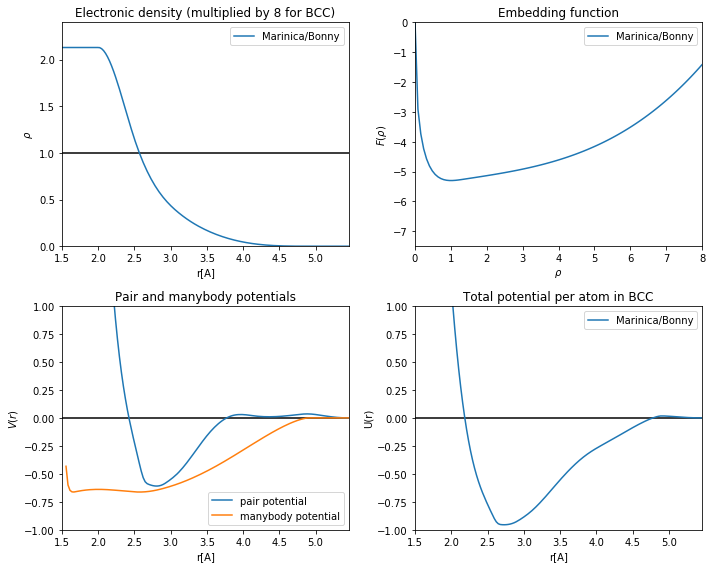

In [877]:
# plot the functions and potentials
rcut = 5.46
r = np.linspace(0., rcut, 201)

plt.figure(figsize=(10,8))

# Electronic density
pot_coh = np.array([rho(x)*8 for x in r])
imax = np.argmax(pot_coh)
pot_coh[0:imax] = pot_coh.max()
plt.subplot(221)
plt.title('Electronic density (multiplied by 8 for BCC)')
plt.plot(r, pot_coh, label='Marinica/Bonny')
plt.legend()
plt.hlines(1.0, 1.5, rcut)
plt.axis([1.5, rcut, 0, 0.3*8])
plt.xlabel('r[A]')
plt.ylabel(r'$ \rho $')

# Embedding function
dens = np.linspace(0., 8., 101)
embed = [Fa(d, F_w_a, Fc_w_a) for d in dens]
plt.subplot(222)
plt.title('Embedding function')
plt.plot(dens, embed, label='Marinica/Bonny')
plt.legend()
plt.axis([0, 8, -7.5, 0.0])
plt.xlabel(r'$\rho$')
plt.ylabel(r'$F(\rho)$')

# Pair and manybody potentials
pot_pair = [V(x, V_w_a, V_w_r) - 2*C*rho(x)/S for x in r]

#pot_pair = [V_pair(x) for x in r]
pot_manybody = [V_man(x) for x in r]
plt.subplot(223)
plt.title('Pair and manybody potentials')
plt.plot(r, pot_pair, label='pair potential')
plt.plot(r, pot_manybody, label='manybody potential')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1.0, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'$V(r)$')

# Total potential per atom (bulk)
pot_tot = [V_pair(x) + V_man(x) for x in r]
plt.subplot(224)
plt.title('Total potential per atom in BCC')
plt.plot(r, pot_tot, label='Marinica/Bonny')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1, 1.0])
#plt.axis([2.65, 2.8, -0.975, -0.925])
plt.xlabel('r[A]')
plt.ylabel(r'U(r)')
#plt.vlines(4.77, -1, 1)

plt.tight_layout()

Extract relevant configuration parameters for optimization

In [874]:
# set of spline nodes
#sc = [2.7, 3.252, 3.804, 4.356, 4.908, 5.46]
sc = [2.56, 2.73, 3.252, 3.804, 4.20, 4.77]

# calculate pair distance matrices (absalute values, components)
rr, rx = pair_dist(xyz, box)

# calculate sufficient statistics for energies and forces from pair distances
stats = get_stats_EAM(rr, rx, sc)

In [305]:
# Cycle over all configurations in a trajectory


In [846]:
# Total pair potential
ene = []
for a in np.linspace(0.5, 2.0, 101):
    z = a*r
    u_pair = np.sum([V_pair(x) for x in z.flatten()])

    u_many = 0.0
    for i in range(z.shape[0]):
        d = np.sum([rho(x) if x > rmax else dmax for x in z[i]])
        u_many += V_many(d)

    ene.append([a, u_pair, u_many, u_pair+u_many])

ene = np.array(ene)
plt.plot(ene[:,0], ene[:,1]/54, label='pair')
plt.plot(ene[:,0], ene[:,2]/54, label='manybody')
plt.plot(ene[:,0], ene[:,3]/54, label='total')
plt.plot(ene[:,0], [eos(x) for x in ene[:,0]], label='EOS')
plt.hlines(0.0,0.5,2.0,lw=1)
plt.legend()
plt.xlim(0.5, 2.0)
plt.ylim(-10,10)

TypeError: 'numpy.float64' object is not iterable

(-1.0, 0)

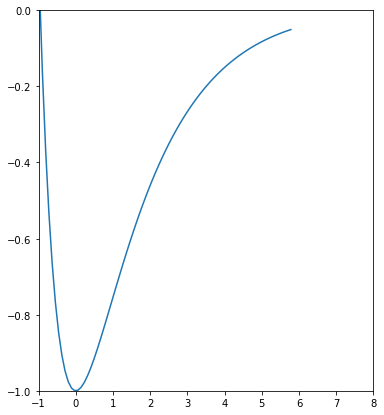

In [275]:
plt.figure(figsize=(6,7))
plt.plot((ene[:,0] - 1)*r_wse/l, [eos(x)/dE for x in ene[:,0]], label='EOS')
plt.xlim(-1.0, 8.0)
plt.ylim(-1.0,0)

In [ ]:
# Calculate 

### Convert potentials into LAMMPS and Yuri formats

#### Pure elements W

In [35]:
# Ranges of densities and separations
rhomax = 10.0
nrho = 5000
drho = rhomax/nrho

nr = 5000
#rcut = 5.46
rcut = 5.4604375
dr = rcut/nr

ri = 1.0
ro = 2.0

# W properties
na = 74
ma = 183.84
lc = 3.1653
alat = 'bcc'

# System composition
n_el = 1
el_name = ['W']

In [37]:
# Cubic spline function for pair potentials and electronic density
f_spline = lambda r, aa, kk: sum([a*(rk - r)**3 for a, rk in zip(aa, kk) if r < rk])

# Functional form for the embedding potential
f_embed = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

# prepare lists of values
dens = np.linspace(0., rhomax-drho, nrho, endpoint=True)
r = np.linspace(0., rcut-dr, nr, endpoint=True)

#fembd = [f_embed(d, F_re_a) for d in dens] # Re
fembd = [Fa(d, F_w_a, Fc_w_a) for d in dens] # W

#edens = [f_spline(x, rho_re_a, rho_re_r) for x in r] # Re
edens = np.array([f_spline(x, rho_w_a, rho_w_r)*S for x in r]) # W
imax = np.argmax(edens)
edens[0:imax] = edens.max()

# Pair potential

# 1. Cubic spline for r > r_o
f_outer = [f_spline(x, V_w_a, V_w_r) - 2*C*edens[i]/S for i, x in enumerate(r)]

# 2. Repulsive core for r < r_i (precalculate up to r_o)
f_inner = [0.0] + [u_core(x) for x in r[1:]]

# 3. Transition region for r_i < r < r_o
fpair = [x*u_trans(x, f_inner[i], f_outer[i]) for i, x in enumerate(r)]

### 3.5 Output optimized potential

In [60]:
# LAMMPS format
with open(os.path.join(pot_path, 'W_lv.eam.fs'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    fo.write(f"{n_el:5d} ")
    for i in range(n_el):
        fo.write(f"{el_name[i]:2}")
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    
    # atomic number, mass, lattice size, lattice type
    fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))